# Warm Up: Predict blood donations
(C) 2018 Dariusz Kajtoch

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. Data Exploration

In [2]:
data = pd.read_csv('./predict_blood_donations.csv')
print(data.columns)
data.columns = ['Id', 'MonthLast', 'Num', 'Vol', 'MonthFirst', 'Predict']
data.head()

Index(['Unnamed: 0', 'Months since Last Donation', 'Number of Donations',
       'Total Volume Donated (c.c.)', 'Months since First Donation',
       'Made Donation in March 2007'],
      dtype='object')


,Id,MonthLast,Num,Vol,MonthFirst,Predict
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [17]:
# check for nulls and distinct values
nulls = data.isnull().sum()
distinct = data.nunique()

print(pd.DataFrame({'NoNulls': nulls.iloc[:], 'NoDistinct': distinct.iloc[:]}))

            NoDistinct  NoNulls
Id                 576        0
MonthLast           29        0
Num                 29        0
Vol                 29        0
MonthFirst          75        0
Predict              2        0


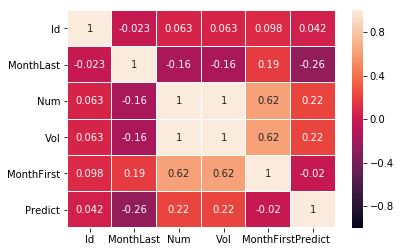

In [24]:
sns.heatmap(data.corr(),
            vmin=-1.,
            vmax=1.,
            annot=True,
            linewidths=.05
           )

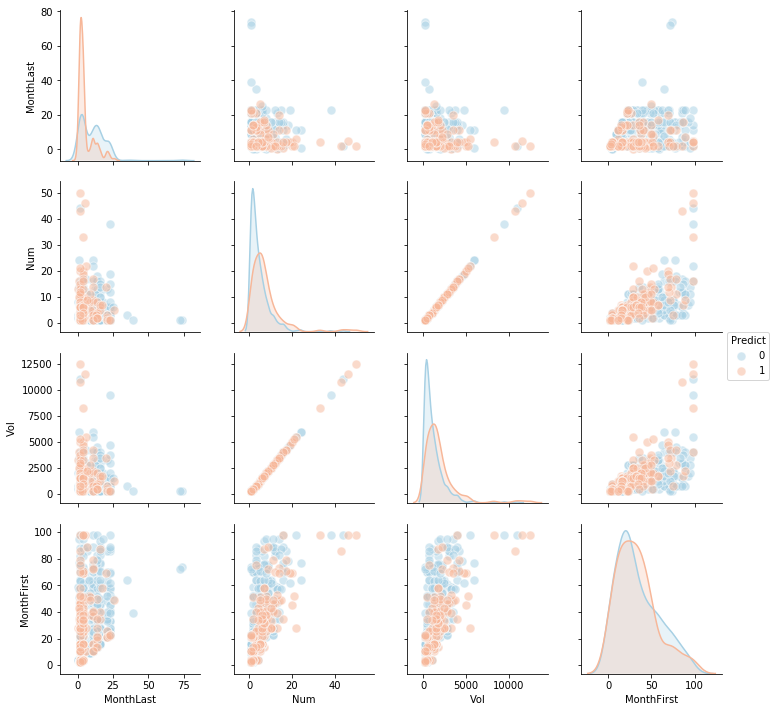

In [49]:
plt.close()
sns.pairplot(data, 
             vars=['MonthLast','Num','Vol','MonthFirst'],
             kind="scatter", 
             diag_kind="kde",
             hue="Predict", 
             plot_kws=dict(s=80, alpha=0.5),
             diag_kws=dict(shade=True),
             palette=sns.color_palette("RdBu_r", 2)
            )

Perfect correlation between `Number of donations` and `Total Volume Donated` can be explained only when the donated amount is always fixed. We can actualy calculate it: $12500/50 = 250 (c.c.)$.

In [96]:
X = data[['MonthLast','Num','MonthFirst']]
X['Ratio'] = X['MonthLast']/X['MonthFirst']
y = data['Predict']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV

# compare logistic regression with and without scaling
estimator = LogisticRegression()

param_grid = {'C': np.linspace(0.001,10,10),
              'penalty': ['l1','l2'],
             }

clf = GridSearchCV(estimator,
                   param_grid=param_grid,
                   scoring=['neg_log_loss','accuracy','roc_auc'],
                   refit='neg_log_loss',
                   return_train_score=False,
                   cv=10
                  )
clf.fit(X,y)

/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.000e-03, 1.112e+00, 2.223e+00, 3.334e+00, 4.445e+00, 5.556e+00,
       6.667e+00, 7.778e+00, 8.889e+00, 1.000e+01]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score=False,
       scoring=['neg_log_loss', 'accuracy', 'roc_auc'], verbose=0)

In [101]:
print(clf.best_score_)
print(clf.best_params_)
print(clf.cv_results_['params'])

-0.5100459318010913
{'C': 0.001, 'penalty': 'l2'}
[{'C': 0.001, 'penalty': 'l1'}, {'C': 0.001, 'penalty': 'l2'}, {'C': 1.1119999999999999, 'penalty': 'l1'}, {'C': 1.1119999999999999, 'penalty': 'l2'}, {'C': 2.223, 'penalty': 'l1'}, {'C': 2.223, 'penalty': 'l2'}, {'C': 3.334, 'penalty': 'l1'}, {'C': 3.334, 'penalty': 'l2'}, {'C': 4.445, 'penalty': 'l1'}, {'C': 4.445, 'penalty': 'l2'}, {'C': 5.556, 'penalty': 'l1'}, {'C': 5.556, 'penalty': 'l2'}, {'C': 6.667000000000001, 'penalty': 'l1'}, {'C': 6.667000000000001, 'penalty': 'l2'}, {'C': 7.7780000000000005, 'penalty': 'l1'}, {'C': 7.7780000000000005, 'penalty': 'l2'}, {'C': 8.889, 'penalty': 'l1'}, {'C': 8.889, 'penalty': 'l2'}, {'C': 10.0, 'penalty': 'l1'}, {'C': 10.0, 'penalty': 'l2'}]


In [92]:
C_val = np.array([x['C'] for x in clf.cv_results_['params']])
C_val = C_val.reshape((10,2))

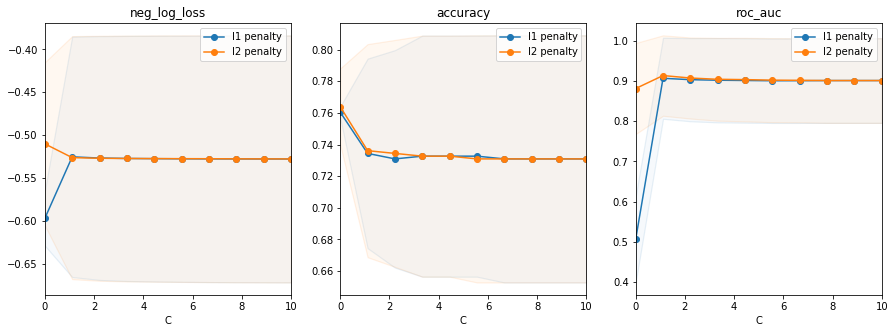

In [100]:
plt.close()

fig, ax_tab = plt.subplots(figsize=(15,5),nrows=1, ncols=3)

tab20 = plt.cm.get_cmap('tab20').colors

for name, ax in zip(['neg_log_loss', 'accuracy', 'roc_auc'], ax_tab):
    yval  = clf.cv_results_['mean_test_%s' % name].reshape((10,2))
    error = clf.cv_results_['std_test_%s' % name].reshape((10,2))
    ax.plot(C_val[:,0], yval[:,0],
            c=tab20[0],
            marker='o',
            lw=1.5,
            label='l1 penalty'
          )
    ax.plot(C_val[:,1], yval[:,1],
            c=tab20[2],
            marker='o',
            lw=1.5,
            label='l2 penalty'
          )
    ax.fill_between(C_val[:,0], yval[:,0]-error[:,0], yval[:,0]+error[:,0], 
                    alpha=0.1,
                    lw=1.2,
                    edgecolor=tab20[0],
                    facecolor=tab20[1]
                   )
    ax.fill_between(C_val[:,1], yval[:,1]-error[:,1], yval[:,1]+error[:,1], 
                    alpha=0.1,
                    lw=1.2,
                    edgecolor=tab20[2],
                    facecolor=tab20[3]
                   )
    ax.set_title(name)
    ax.set_xlim(0,10)
    ax.set_xlabel('C')
    ax.legend()

In [117]:
est = clf.best_estimator_

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

skf = StratifiedKFold(n_splits=40,
                      shuffle=True
                     )

skf40 = []
for train_index, test_index in skf.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test   = X.iloc[test_index], y.iloc[test_index]
    
    est.fit(X_train, y_train)
    
    skf40.append(log_loss(y_test, est.predict_proba(X_test)))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe3a0996fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe3a099d8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe3a0996e80>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe3a09a5160>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe3a09a5588>,
 'means': []}

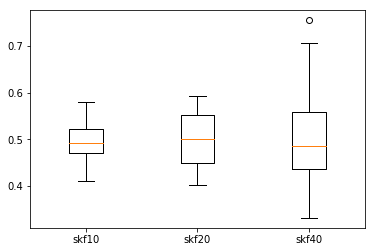

In [118]:
plt.close()

fig, ax = plt.subplots()

ax.boxplot([skf10, skf20, skf40], labels=['skf10', 'skf20', 'skf40'])

# To do:
1. We have only 3 features so we can visualize them using `mayavi`.
2. SVM maybe a good choice.
3. Neural networks with Keras.
4. Feature engineering like Ratio.
3. Methods of validation.

# Neural Network with KERAS

In [14]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(32, input_dim=4, kernel_initializer='uniform', activation='relu'))
model.add(Dense(16, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
data = pd.read_csv('./predict_blood_donations.csv')
data.columns = ['Id', 'MonthLast', 'Num', 'Vol', 'MonthFirst', 'Predict']

X = data[['MonthLast','Num','MonthFirst']]
# new feature
X['Ratio'] = X['MonthLast']/X['MonthFirst']
y = data['Predict']

from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

clf = Pipeline([('feature', StandardScaler()), ('model', model)])

skf = StratifiedKFold(n_splits=10, shuffle=True)

for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    clf.fit(X_train, y_train, model__epochs=10, model__batch_size=10)
    
    print(log_loss(y_test, clf.predict_proba(X_test)))

    

Epoch 1/10
 50/518 [=>............................] - ETA: 1s - loss: 0.5251 - acc: 0.7200

/opt/intel/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


518/518 [==============================] - 2s 3ms/step - loss: 0.4913 - acc: 0.7664
Epoch 2/10
518/518 [==============================] - 1s 3ms/step - loss: 0.4859 - acc: 0.7645
Epoch 3/10
518/518 [==============================] - 1s 3ms/step - loss: 0.4840 - acc: 0.7761
Epoch 4/10
518/518 [==============================] - 2s 3ms/step - loss: 0.4821 - acc: 0.7741
Epoch 5/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4807 - acc: 0.7722
Epoch 6/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4794 - acc: 0.7896
Epoch 7/10
518/518 [==============================] - 1s 3ms/step - loss: 0.4792 - acc: 0.7780
Epoch 8/10
518/518 [==============================] - 2s 3ms/step - loss: 0.4783 - acc: 0.7876
Epoch 9/10
518/518 [==============================] - 1s 3ms/step - loss: 0.4777 - acc: 0.7915
Epoch 10/10
518/518 [==============================] - 2s 4ms/step - loss: 0.4766 - acc: 0.7915
0.39119430008376466
Epoch 1/10
518/518 [====================

520/520 [==============================] - 1s 2ms/step - loss: 0.4629 - acc: 0.8115
Epoch 3/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4637 - acc: 0.8096
Epoch 4/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4627 - acc: 0.8115
Epoch 5/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4617 - acc: 0.8115
Epoch 6/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4619 - acc: 0.8115
Epoch 7/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4610 - acc: 0.8135
Epoch 8/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4636 - acc: 0.8077
Epoch 9/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4622 - acc: 0.8096
Epoch 10/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4624 - acc: 0.8115
0.38181227306943455
Epoch 1/10
520/520 [==============================] - 1s 2ms/step - loss: 0.4533 - acc: 0.8115
Epoch 2/10
520/520 [====================